## Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_recall_fscore_support, roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install -U datasets

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
!ls


sample_data		       train_dataset_preprocessed.csv
test.csv		       validation.csv
test_dataset_preprocessed.csv  validation_dataset_preprocessed.csv
train.csv


In [5]:
def load_and_explore_data(file_path):
    """
    Load the dataset and perform initial exploration
    Expected format: CSV with columns 'sentence' and 'label'
    Labels should be: 'support', 'refute', 'not enough information'
    """

    # Load the dataset
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    print(df.head())

    # Check for missing values
    print(f"\nMissing values:\n{df.isnull().sum()}")

    # Analyze class distribution
    class_counts = df['claims_labels'].value_counts()
    print(f"\nClass distribution:")
    print(class_counts)
    print(f"\nClass proportions:")
    print(df['claims_labels'].value_counts(normalize=True))

    # Visualize class distribution
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Class Distribution (Count)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    df['claims_labels'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
    plt.title('Class Distribution (Percentage)')

    plt.tight_layout()
    plt.show()

    # Text length analysis
    df['text_length'] = df['claims'].str.len()
    df['word_count'] = df['claims'].str.split().str.len()

    print(f"\nText statistics:")
    print(df[['text_length', 'word_count']].describe())

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    df['text_length'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Text Length (characters)')
    plt.xlabel('Character count')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    df['word_count'].hist(bins=50, alpha=0.7)
    plt.title('Distribution of Word Count')
    plt.xlabel('Word count')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return df

In [6]:
def check_class_imbalance(df, threshold=0.6):
    """
    Check if dataset has significant class imbalance
    """
    class_proportions = df['claims_labels'].value_counts(normalize=True)
    max_proportion = class_proportions.max()

    print(f"Maximum class proportion: {max_proportion:.3f}")

    if max_proportion > threshold:
        print(f"⚠️  Class imbalance detected! Majority class has {max_proportion:.1%} of samples")
        return True
    else:
        print("✅ Classes are relatively balanced")
        return False

In [7]:
# data_file_path = 'cleaned_data_no_special_characters.csv'

In [8]:
# df = load_and_explore_data(data_file_path)

In [9]:
# from datasets import load_dataset
# import pandas as pd

# # 1. Load the dataset
# dataset = load_dataset("amandakonet/climate_fever_adopted")

# # 2. Convert to pandas DataFrames and keep only required columns
# train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

In [10]:
# from datasets import load_dataset
# import pandas as pd

# # 1. Load the datasetJasontth/climate_fever_plus
# dataset = load_dataset("Jasontth/climate_fever_plus")

# # 2. Convert to pandas DataFrames and keep only required columns
# train_df = pd.DataFrame(dataset['train'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# val_df = pd.DataFrame(dataset['valid'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})
# test_df = pd.DataFrame(dataset['test'])[["claim", "evidence_label"]].rename(columns={"claim": "claims", "evidence_label": "claims_labels"})

In [11]:
import pandas as pd

# Load all three datasets
train_df = pd.read_csv('/content/train_dataset_preprocessed.csv', usecols=['claims', 'claims_labels'])
test_df = pd.read_csv('/content/test_dataset_preprocessed.csv', usecols=['claims', 'claims_labels'])
val_df = pd.read_csv('/content/validation_dataset_preprocessed.csv', usecols=['claims', 'claims_labels'])

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Validation: {val_df.shape}")

Train: (6833, 2)
Test: (767, 2)
Validation: (768, 2)


In [12]:
# Define label to remove
label_to_remove = "NOT_ENOUGH_INFO"

# Filter out that label from each DataFrame
train_df = train_df[train_df["claims_labels"] != label_to_remove].reset_index(drop=True)
val_df = val_df[val_df["claims_labels"] != label_to_remove].reset_index(drop=True)
test_df = test_df[test_df["claims_labels"] != label_to_remove].reset_index(drop=True)

# Confirm updated class distributions
print("✅ Train class distribution:")
print(train_df["claims_labels"].value_counts())

print("\n✅ Validation class distribution:")
print(val_df["claims_labels"].value_counts())

print("\n✅ Test class distribution:")
print(test_df["claims_labels"].value_counts())


✅ Train class distribution:
claims_labels
SUPPORTS    1690
REFUTES     1159
Name: count, dtype: int64

✅ Validation class distribution:
claims_labels
SUPPORTS    219
REFUTES      79
Name: count, dtype: int64

✅ Test class distribution:
claims_labels
SUPPORTS    203
REFUTES      88
Name: count, dtype: int64


In [13]:
def calculate_class_weights(train_labels):
    """
    Calculate class weights for weighted cross-entropy loss
    """
    from collections import Counter

    # Map labels to numerical format
    label_map = {'REFUTES': 0, 'SUPPORTS': 1} # Ensure this matches the dataset mapping
    numerical_labels = [label_map[label] for label in train_labels]

    # Count occurrences of each class
    class_counts = Counter(numerical_labels)
    total_samples = len(numerical_labels)

    # Calculate weights (inverse frequency)
    # Ensure weights are calculated and returned in the order of numerical labels (0, 1)
    weight_list = [0] * len(label_map)
    for class_id, count in class_counts.items():
        weight_list[class_id] = total_samples / (len(class_counts) * count)

    print(f"Class distribution: {class_counts}")
    print(f"Class weights (ordered by label ID): {weight_list}")

    return weight_list

In [14]:
 # Calculate class weights from training data
# The label_map in calculate_class_weights should match the label_map in ClimateClaimDataset
class_weights = calculate_class_weights(train_df['claims_labels'])

Class distribution: Counter({1: 1690, 0: 1159})
Class weights (ordered by label ID): [1.229076790336497, 0.8428994082840237]


In [15]:
def create_train_val_test_split(df, train_size=0.8, val_size=0.10, test_size=0.10, random_state=42):
    """
    Create stratified train/validation/test splits
    """

    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1.0"

    # First split: train and temp (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df['claims_labels'],
        random_state=random_state
    )

    # Second split: validation and test from temp
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio,
        stratify=temp_df['claims_labels'],
        random_state=random_state
    )

    print("Data split summary:")
    print(f"Train: {len(train_df)} samples ({len(train_df)/len(df):.1%})")
    print(f"Validation: {len(val_df)} samples ({len(val_df)/len(df):.1%})")
    print(f"Test: {len(test_df)} samples ({len(test_df)/len(df):.1%})")

    # Check class distribution in each split
    print(f"\nClass distribution in splits:")
    for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
        print(f"\n{split_name}:")
        print(split_df['claims_labels'].value_counts())

    return train_df, val_df, test_df

In [16]:
#  train_df, val_df, test_df = create_train_val_test_split(df)

## DATASET CLASS FOR PYTORCH

In [17]:

class ClimateClaimDataset(Dataset):
    def __init__(self, claims, labels, tokenizer, max_length=256):
        self.claims = claims
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Create label mapping
        unique_labels = sorted(list(set(labels)))
        self.label2id = {label: i for i, label in enumerate(unique_labels)}
        self.id2label = {i: label for label, i in self.label2id.items()}

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = str(self.claims[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            claim,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label2id[label], dtype=torch.long)
        }


## MODEL SETUP AND TRAINING

In [18]:
# import torch
# import torch.nn as nn
# from transformers import AutoModel, AutoConfig

# class ClimateBERTWithFFHead(nn.Module):
#     def __init__(self, model_name, num_labels=2, dropout_rate=0.3, class_weights=None):
#         super().__init__()

#         self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
#         self.base_model = AutoModel.from_pretrained(model_name, config=self.config)

#         self.class_weights = class_weights  # store weights if provided

#         hidden_size = self.config.hidden_size

#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size),
#             nn.Tanh(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, num_labels)
#         )

#     def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
#         outputs = self.base_model(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict=True,
#         )

#         pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
#         logits = self.classifier(pooled_output)

#         loss = None
#         if labels is not None:
#             if self.class_weights is not None:
#                 # Ensure class weights are a tensor and on the correct device
#                 weight_tensor = torch.tensor(
#                     self.class_weights, dtype=torch.float32, device=logits.device
#                 )
#                 loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
#             else:
#                 loss_fct = nn.CrossEntropyLoss()

#             loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

#         return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [19]:
class WeightedTrainer(Trainer):
    """
    Custom trainer with class weights and label smoothing for handling imbalanced datasets
    """
    def __init__(self, class_weights=None, label_smoothing=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Compute weighted loss with label smoothing
        if self.class_weights is not None:
            # Convert class weights to tensor
            weight_tensor = torch.tensor(
                [self.class_weights[i] for i in range(len(self.class_weights))],
                dtype=torch.float32,
                device=labels.device
            )
            loss_fct = torch.nn.CrossEntropyLoss(
                weight=weight_tensor,
                label_smoothing=self.label_smoothing
            )
        else:
            # Standard loss with label smoothing
            loss_fct = torch.nn.CrossEntropyLoss(label_smoothing=self.label_smoothing)

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

def setup_model_and_tokenizer(model_name="climatebert/distilroberta-base-climate-f", num_labels=2, class_weights=None):
    """
    Setup ClimateBERT model with dropout=0.3 and optional class weights
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model with custom dropout
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        attention_probs_dropout_prob=0.3,    # Set attention dropout
        hidden_dropout_prob=0.3,             # Set hidden dropout
        classifier_dropout=0.3                # Set classifier dropout
    )

    return model, tokenizer

def create_datasets(train_df, val_df, test_df, tokenizer, max_length=512):
    """
    Create dataset objects for training
    """
    train_dataset = ClimateClaimDataset(
        train_df['claims'].tolist(),
        train_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    val_dataset = ClimateClaimDataset(
        val_df['claims'].tolist(),
        val_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    test_dataset = ClimateClaimDataset(
        test_df['claims'].tolist(),
        test_df['claims_labels'].tolist(),
        tokenizer,
        max_length
    )

    return train_dataset, val_dataset, test_dataset



def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics including AUC
    """
    import torch.nn.functional as F
    predictions, labels = eval_pred

    # Get predicted probabilities for AUC calculation
    probs = F.softmax(torch.tensor(predictions), dim=-1).numpy()
    predicted_labels = np.argmax(predictions, axis=1)

    # Overall accuracy
    accuracy = accuracy_score(labels, predicted_labels)

    # Class-wise metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predicted_labels, average=None, zero_division=0
    )

    # Macro and weighted averages
    f1_macro = f1_score(labels, predicted_labels, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predicted_labels, average='weighted', zero_division=0)

    # AUC calculation (for binary classification)
    try:
        if len(np.unique(labels)) == 2:  # Binary classification
            auc = roc_auc_score(labels, probs[:, 1])  # Use probability of positive class
        else:
            auc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
    except ValueError:
        auc = 0.0  # Fallback if AUC can't be calculated


    class_labels = {'REFUTES': 0, 'SUPPORTS': 1} # Ensure this matches the label_map used elsewhere

    # Metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'auc': auc
    }

    # Add class-specific metrics with label names
    for i in range(len(f1)):
        # Get label name from the class_labels dictionary
        label_name = class_labels.get(i, f'class_{i}')
        metrics[f'f1_{label_name}'] = f1[i]
        metrics[f'precision_{label_name}'] = precision[i]
        metrics[f'recall_{label_name}'] = recall[i]


    return metrics


def train_model(model, train_dataset, val_dataset, class_weights=None, output_dir="./climate-claim-classifier"):
    """
    Train the model following ClimateBERT paper hyperparameters
    """

    """
    Train the model with your specified configuration
    """

    # YOUR SPECIFIED CONFIGURATION
    training_args = TrainingArguments(
        output_dir=output_dir,

        # Training parameters
        num_train_epochs=10,                    # 10 epochs as specified
        per_device_train_batch_size=16,         # Batch size 16 as specified
        per_device_eval_batch_size=16,

        # Optimizer and learning rate
        learning_rate=2e-5,                     # Learning rate 2e-5 as specified
        weight_decay=0.01,                      # Weight decay for AdamW
        adam_beta1=0.9,                         # AdamW parameters
        adam_beta2=0.999,
        adam_epsilon=1e-8,

        # Learning rate scheduling
        warmup_ratio=0.1,                       # Warm-up for better training
        lr_scheduler_type="linear",

        # Evaluation and saving
        eval_strategy="epoch",                  # Evaluate every epoch
        save_strategy="epoch",                  # Save every epoch
        load_best_model_at_end=True,           # Load best model based on metric
        metric_for_best_model="f1_macro",      # Use F1-score for early stopping
        greater_is_better=True,
        save_total_limit=3,                     # Keep only 3 best models

        # Early stopping will be handled by callback

        # Logging
        logging_dir='./logs',
        logging_steps=50,
        logging_strategy="steps",

        # Other configurations
        seed=42,
        dataloader_drop_last=False,
        push_to_hub=False,
        fp16=torch.cuda.is_available(),         # Use FP16 if CUDA available
        dataloader_pin_memory=True,
        remove_unused_columns=True,
        report_to=None,                         # Disable wandb/tensorboard
        max_grad_norm=1.0,                      # Gradient clipping
        dataloader_num_workers=2,
    )

    # Create trainer with specified configurations
    trainer = WeightedTrainer(
        class_weights=class_weights,            # Weighted Cross-Entropy
        label_smoothing=0.1,                   # Label smoothing 0.1
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,        # Precision, Recall, F1, AUC
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=2,     # Early stopping based on validation F1
                early_stopping_threshold=0.001
            )
        ]
    )

    print("=" * 60)
    print("TRAINING CONFIGURATION:")
    print("=" * 60)
    print(f"🔧 Loss Function: Weighted Cross-Entropy + Label Smoothing (0.1)")
    print(f"🔧 Dropout: 0.3 (set in model)")
    print(f"🔧 Optimizer: AdamW")
    print(f"🔧 Learning Rate: 2e-5")
    print(f"🔧 Batch Size: 16")
    print(f"🔧 Epochs: 10")
    print(f"🔧 Early Stopping: Based on Validation F1-score")
    print(f"🔧 Evaluation Metrics: Precision, Recall, F1-score, AUC")
    print(f"🔧 Class Weights: {class_weights}")
    print("=" * 60)

    print("Starting training...")
    trainer.train()
    trainer.save_model()

    return trainer

In [20]:

def stratified_cross_validation(df, model_name="climatebert/distilroberta-base-climate-f",
                               n_splits=5, max_length=256):
    """
    Perform 5-fold stratified cross-validation as specified
    """
    print("=" * 60)
    print("PERFORMING 5-FOLD STRATIFIED CROSS-VALIDATION")
    print("=" * 60)

    # Prepare data
    texts = df['claims'].tolist()
    labels = df['claims_labels'].tolist()

    # Convert labels to numerical format
    label_map = {'REFUTES': 0, 'SUPPORTS': 1}
    numerical_labels = [label_map[label] for label in labels]

    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store results
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, numerical_labels)):
        print(f"\n🔄 FOLD {fold + 1}/{n_splits}")
        print("-" * 40)

        # Split data
        train_texts = [texts[i] for i in train_idx]
        train_labels = [numerical_labels[i] for i in train_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = [numerical_labels[i] for i in val_idx]

        # Calculate class weights for this fold
        class_weights = calculate_class_weights(train_labels)

        # Setup model and tokenizer
        model, tokenizer = setup_model_and_tokenizer(
            model_name=model_name,
            num_labels=2,
            class_weights=class_weights
        )

        # Create datasets
        train_dataset = ClimateClaimDataset(train_texts, train_labels, tokenizer, max_length)
        val_dataset = ClimateClaimDataset(val_texts, val_labels, tokenizer, max_length)

        # Train model
        trainer = train_model_with_config(
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            class_weights=class_weights,
            output_dir=f"./cv_fold_{fold + 1}"
        )

        # Evaluate
        eval_results = trainer.evaluate()
        cv_results.append(eval_results)

        print(f"Fold {fold + 1} Results:")
        print(f"  Accuracy: {eval_results['eval_accuracy']:.4f}")
        print(f"  F1-Macro: {eval_results['eval_f1_macro']:.4f}")
        print(f"  AUC: {eval_results['eval_auc']:.4f}")

    # Calculate average results
    print("\n" + "=" * 60)
    print("CROSS-VALIDATION SUMMARY")
    print("=" * 60)

    avg_accuracy = np.mean([r['eval_accuracy'] for r in cv_results])
    avg_f1 = np.mean([r['eval_f1_macro'] for r in cv_results])
    avg_auc = np.mean([r['eval_auc'] for r in cv_results])

    std_accuracy = np.std([r['eval_accuracy'] for r in cv_results])
    std_f1 = np.std([r['eval_f1_macro'] for r in cv_results])
    std_auc = np.std([r['eval_auc'] for r in cv_results])

    print(f"📊 Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"📊 Average F1-Macro: {avg_f1:.4f} ± {std_f1:.4f}")
    print(f"📊 Average AUC: {avg_auc:.4f} ± {std_auc:.4f}")

    return cv_results

In [21]:

def evaluate_model(trainer, test_dataset, label_names):
    """
    Evaluate the trained model on test set with detailed class-wise metrics
    """
    from sklearn.metrics import classification_report, confusion_matrix, f1_score

    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Calculate overall metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {f1_macro:.4f}")
    print(f"Weighted F1-score: {f1_weighted:.4f}")

    # Detailed classification report
    print(f"\n Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Class-wise F1 scores
    class_f1_scores = f1_score(y_true, y_pred, average=None)
    print(f"\nClass-wise F1-scores:")
    for i, (label, f1) in enumerate(zip(label_names, class_f1_scores)):
        print(f"  {label}: {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Class-wise F1 scores visualization
    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_names, class_f1_scores, color=['#ff9999', '#66b3ff', '#99ff99'])
    plt.title('Class-wise F1-scores')
    plt.ylabel('F1-score')
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, f1_macro, y_pred, y_true

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(trainer):
    """
    Plot training and validation metrics over time (for binary classes: support and refute only)
    """
    log_history = trainer.state.log_history

    # Extract training and evaluation metrics
    train_metrics = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_metrics = [log for log in log_history if 'eval_loss' in log]

    if not eval_metrics:
        print("No evaluation metrics found in training history.")
        return

    # Extract steps and metrics
    eval_steps = [log['step'] for log in eval_metrics]
    eval_accuracy = [log.get('eval_accuracy', 0) for log in eval_metrics]
    eval_f1_macro = [log.get('eval_f1_macro', 0) for log in eval_metrics]
    eval_f1_weighted = [log.get('eval_f1_weighted', 0) for log in eval_metrics]


    # Class-wise F1 scores (for only support and refute)
    eval_f1_support = [log.get('eval_f1_class_1', 0) for log in eval_metrics]
    eval_f1_refute = [log.get('eval_f1_class_0', 0) for log in eval_metrics]


    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Overall metrics
    axes[0, 0].plot(eval_steps, eval_accuracy, 'b-o', label='Accuracy')
    axes[0, 0].plot(eval_steps, eval_f1_macro, 'r-o', label='Macro F1')
    axes[0, 0].plot(eval_steps, eval_f1_weighted, 'g-o', label='Weighted F1')
    axes[0, 0].set_title('Overall Validation Metrics')
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Class-wise F1 scores
    axes[0, 1].plot(eval_steps, eval_f1_support, 'b-o', label='Support F1')
    axes[0, 1].plot(eval_steps, eval_f1_refute, 'r-o', label='Refute F1')
    axes[0, 1].set_title('Class-wise F1 Scores')
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training and validation loss
    train_steps = [log['step'] for log in train_metrics if 'loss' in log]
    train_loss = [log['loss'] for log in train_metrics if 'loss' in log]
    eval_loss = [log.get('eval_loss', 0) for log in eval_metrics]

    if train_steps and train_loss:
        axes[1, 0].plot(train_steps, train_loss, 'b-', label='Training Loss')
        axes[1, 0].plot(eval_steps, eval_loss, 'r-o', label='Validation Loss')
        axes[1, 0].set_title('Training and Validation Loss')
        axes[1, 0].set_xlabel('Training Steps')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # Learning rate schedule
    learning_rates = [log.get('learning_rate', 0) for log in train_metrics if 'learning_rate' in log]
    lr_steps = [log['step'] for log in train_metrics if 'learning_rate' in log]

    if lr_steps and learning_rates:
        axes[1, 1].plot(lr_steps, learning_rates, 'g-')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


In [24]:
model, tokenizer = setup_model_and_tokenizer(num_labels=2,class_weights=class_weights)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
train_dataset, val_dataset, test_dataset = create_datasets(
        train_df, val_df, test_df, tokenizer
    )

In [26]:
train_dataset.label2id

{'REFUTES': 0, 'SUPPORTS': 1}

In [27]:
print(train_dataset.label2id)

{'REFUTES': 0, 'SUPPORTS': 1}


In [28]:
print(val_dataset.id2label)

{0: 'REFUTES', 1: 'SUPPORTS'}


In [29]:
trainer = train_model(model, train_dataset, val_dataset, class_weights=class_weights)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


TRAINING CONFIGURATION:
🔧 Loss Function: Weighted Cross-Entropy + Label Smoothing (0.1)
🔧 Dropout: 0.3 (set in model)
🔧 Optimizer: AdamW
🔧 Learning Rate: 2e-5
🔧 Batch Size: 16
🔧 Epochs: 10
🔧 Early Stopping: Based on Validation F1-score
🔧 Evaluation Metrics: Precision, Recall, F1-score, AUC
🔧 Class Weights: [1.229076790336497, 0.8428994082840237]
Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: imaanibrar86 (imaanibrar86-nust) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Auc,F1 Class 0,Precision Class 0,Recall Class 0,F1 Class 1,Precision Class 1,Recall Class 1
1,0.698400,0.708668,0.265101,0.209549,0.111103,0.639934,0.419098,0.265101,1.000000,0.000000,0.000000,0.000000
2,0.681100,0.664752,0.630872,0.591984,0.651162,0.672273,0.466019,0.377953,0.607595,0.717949,0.818713,0.639269
3,0.637100,0.637669,0.687919,0.658842,0.705634,0.735738,0.559242,0.446970,0.746835,0.758442,0.879518,0.666667
4,0.580600,0.596605,0.765101,0.715912,0.771448,0.775822,0.597701,0.547368,0.658228,0.834123,0.866995,0.803653
5,0.579800,0.587243,0.728188,0.695976,0.742468,0.802150,0.597015,0.491803,0.759494,0.794937,0.892045,0.716895
6,0.537800,0.555295,0.808725,0.755537,0.809107,0.808161,0.641509,0.637500,0.645570,0.869565,0.871560,0.867580
7,0.511900,0.551200,0.798658,0.754827,0.803528,0.830039,0.651163,0.602151,0.708861,0.858491,0.887805,0.831050
8,0.466000,0.547101,0.815436,0.764115,0.815805,0.836310,0.654088,0.650000,0.658228,0.874142,0.876147,0.872146
9,0.502100,0.553333,0.832215,0.779220,0.830037,0.835761,0.671053,0.698630,0.645570,0.887387,0.875556,0.899543
10,0.494500,0.553051,0.825503,0.772345,0.824027,0.836223,0.662338,0.680000,0.645570,0.882353,0.874439,0.890411


Test Results:
Accuracy: 0.8144
Macro F1-score: 0.7690
Weighted F1-score: 0.8095

 Detailed Classification Report:
              precision    recall  f1-score   support

     REFUTES     0.7297    0.6136    0.6667        88
    SUPPORTS     0.8433    0.9015    0.8714       203

    accuracy                         0.8144       291
   macro avg     0.7865    0.7576    0.7690       291
weighted avg     0.8090    0.8144    0.8095       291


Class-wise F1-scores:
  REFUTES: 0.6667
  SUPPORTS: 0.8714


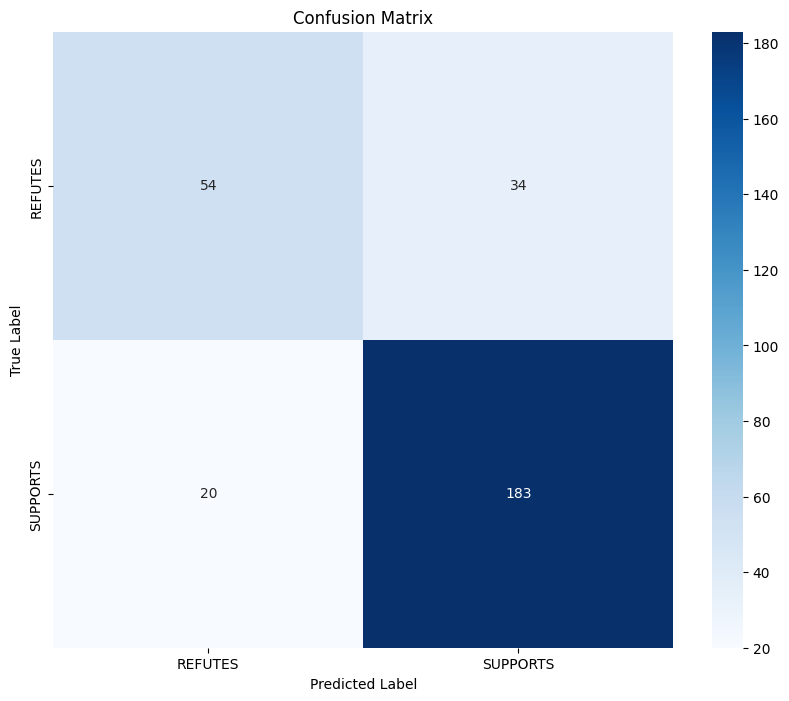

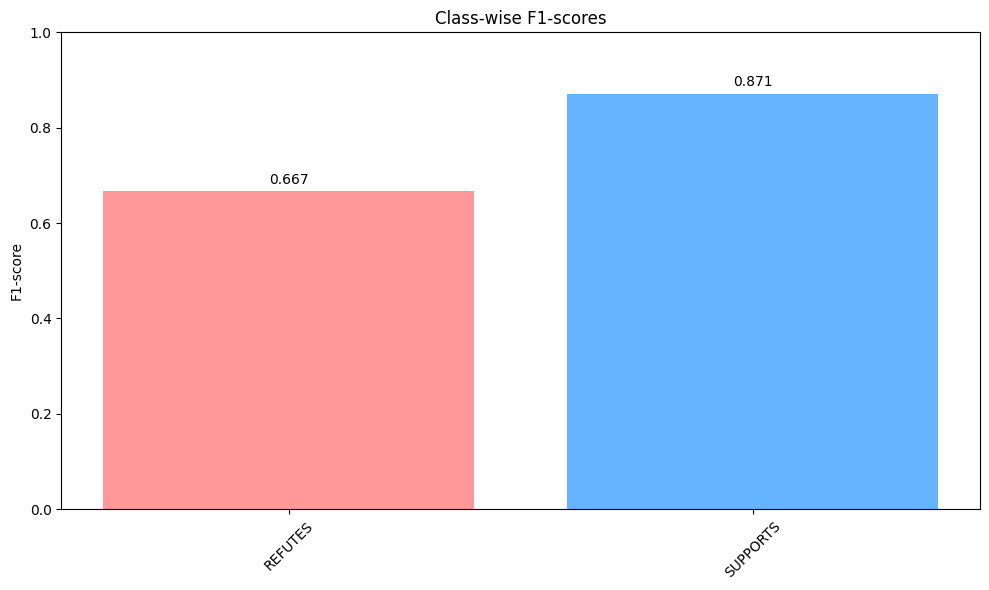

In [30]:

label_names = sorted(train_df['claims_labels'].unique())
accuracy, f1_macro, y_pred, y_true = evaluate_model(trainer, test_dataset, label_names)



In [31]:
from pprint import pprint
for log in trainer.state.log_history:
    if 'val_loss' in log:
        pprint(log)


In [32]:
print(f"\nPipeline completed!")
print(f"Final Results:")
print(f"   - Test accuracy: {accuracy:.4f}")
print(f"   - Macro F1-score: {f1_macro:.4f}")


Pipeline completed!
Final Results:
   - Test accuracy: 0.8144
   - Macro F1-score: 0.7690


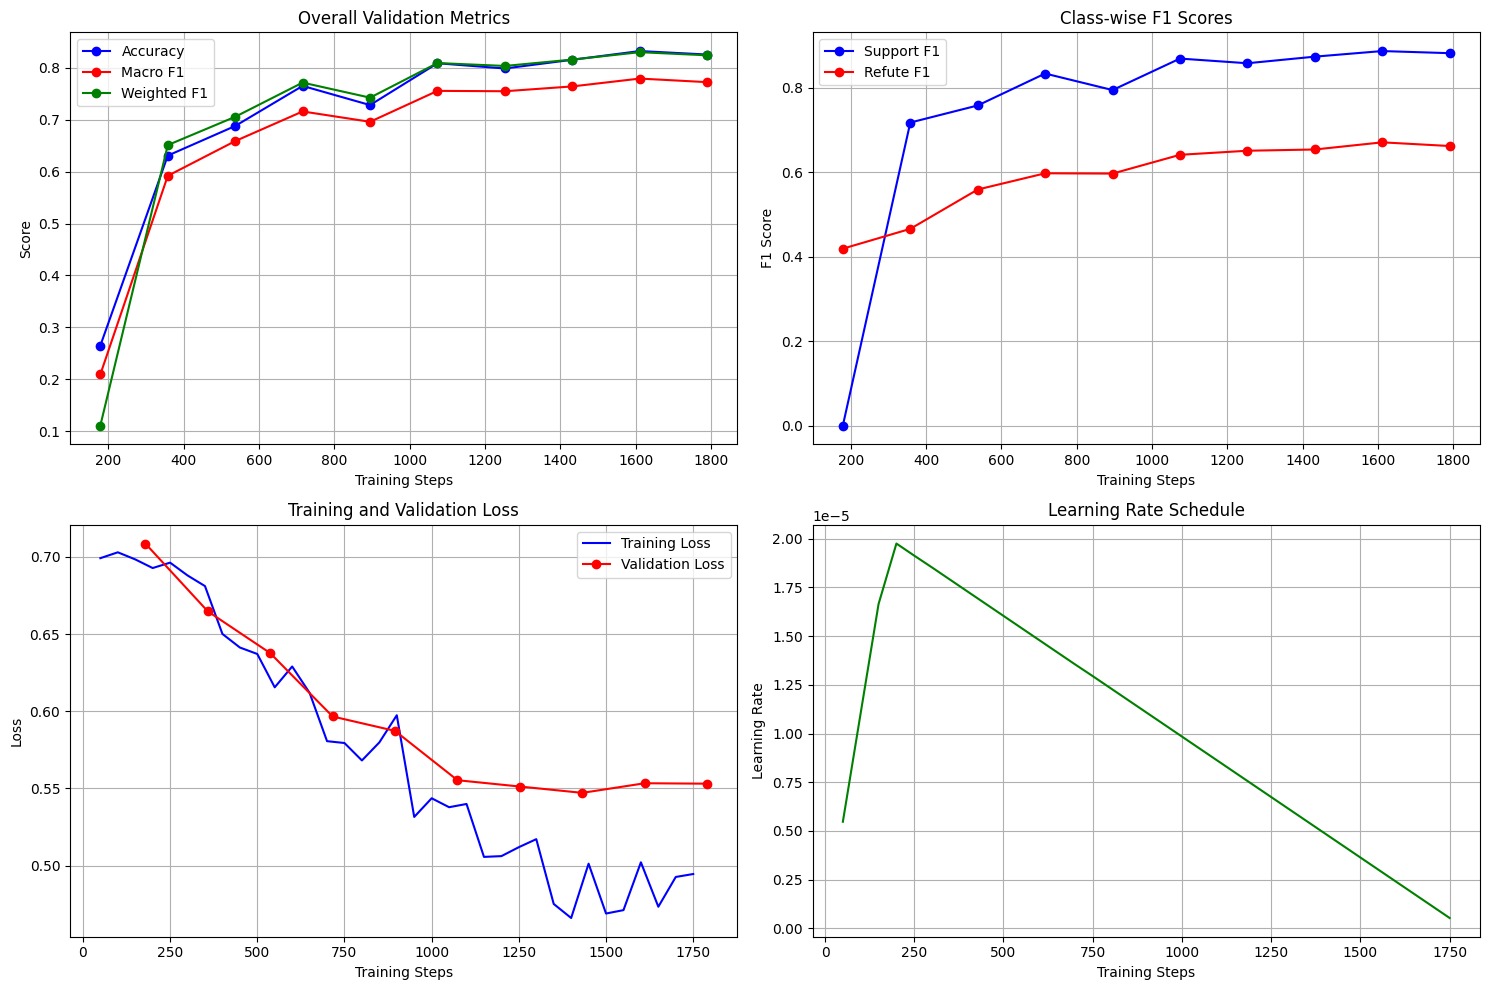

In [33]:
plot_training_history(trainer)

In [34]:
trainer.save_model("./climate_bert_2_label_wch")
tokenizer.save_pretrained("./climate_bert_2_label_wch")
model.config.save_pretrained("./climate_bert_2_label_wch")

In [35]:
import shutil

shutil.make_archive("/content/climate_bert_2_label_wch", 'zip', "./climate_bert_2_label_wch")


'/content/climate_bert_2_label_wch.zip'

In [36]:
from google.colab import files
files.download('/content/climate_bert_2_label_wch.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Generating groundtruth colab: https://colab.research.google.com/drive/1bSpBF9-vLyo7Zh7q_QYV0d_GWGvipZle

Pretrained ClimateBERT Full: https://huggingface.co/climatebert/distilroberta-base-climate-f

Fine tuning tutorial: https://huggingface.co/docs/transformers/training

Layer freezing: https://discuss.huggingface.co/t/freeze-lower-layers-with-auto-classification-model/11386

F1 score?: https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html